# OVERVIEW

This iPython Notebook uses the **_Boston Housing_** data set to illustrate the following:

- The **$k$-Nearest Neighbors** (**KNN**) algorithm;
- The **Bias-Variance Trade-Off**; and
- The use of **Cross Validation** to estimate Out-of-Sample (OOS) prediction error and determine optimal hyper-parameters, in this case the number of nearest neighbors $k$. 

# _first, some boring logistics..._

Let's first import some necessary Python packages and helper modules, and set the random number generator's seed:

In [1]:
# enable In-Line MatPlotLib
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import log, nan, sqrt
import os
from pandas import DataFrame, melt, read_csv
from random import seed
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor

/home/mkolar/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# set CONSTANTS

# data paths
DATA_FILE_NAME = 'BostonHousing.csv'
DATA_URL = 'https://raw.githubusercontent.com/ChicagoBoothML/DATA___BostonHousing/master/%s' % DATA_FILE_NAME

# number of examples to show from a data set
NB_EXAMPLES_TO_SHOW = 9

# random seed
RANDOM_SEED = 99

In [3]:
def rmse(y_hat, y):
    return sqrt(mse(y_hat, y))

def mse(y_hat, y):
    return ((y_hat - y) ** 2).mean()


seed(99)

# Boston Housing data set

Let's now import the Boston Housing data into a **`pandas`** data frame:

In [5]:
# read Boston Housing data into data frame
boston_housing = read_csv(
    'https://raw.githubusercontent.com/ChicagoBoothML/DATA___BostonHousing/master/BostonHousing.csv')
boston_housing.sort_values(by='lstat', inplace=True)
nb_samples = len(boston_housing)
boston_housing[:NB_EXAMPLES_TO_SHOW]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
161,1.46336,0.0,19.58,0,0.6050,7.489,90.8,1.9709,5,403,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1,0.6050,7.802,98.2,2.0407,5,403,14.7,389.61,1.92,50.0
40,0.03359,75.0,2.95,0,0.4280,7.024,15.8,5.4011,3,252,18.3,395.62,1.98,34.9
232,0.57529,0.0,6.20,0,0.5070,8.337,73.3,3.8384,8,307,17.4,385.91,2.47,41.7
192,0.08664,45.0,3.44,0,0.4370,7.178,26.3,6.4798,5,398,15.2,390.49,2.87,36.4
204,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55,2.88,50.0
3,0.03237,0.0,2.18,0,0.4580,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
370,6.53876,0.0,18.10,1,0.6310,7.016,97.5,1.2024,24,666,20.2,392.05,2.96,50.0
195,0.01381,80.0,0.46,0,0.4220,7.875,32.0,5.6484,4,255,14.4,394.23,2.97,50.0


Let us then focus on the two variables of interest: **`lstat`** (our predictor variable(s) $\mathbf X$) and **`medv`** (our variable to predict $\mathbf y$). Below is a plot of them against each other:

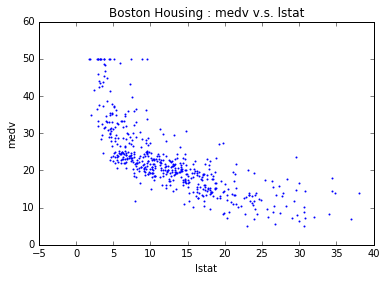

In [6]:
lstat = boston_housing['lstat']
medv = boston_housing['medv']
plt.scatter(lstat, medv, s = 1, color = 'blue')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('Boston Housing : medv v.s. lstat')

# $k$-Nearest Neighbors algorithm and Bias-Variance Trade-Off

Let's now try fitting a KNN predictor, with $k = 5$, of _medv_ from _lstat_, using all samples:

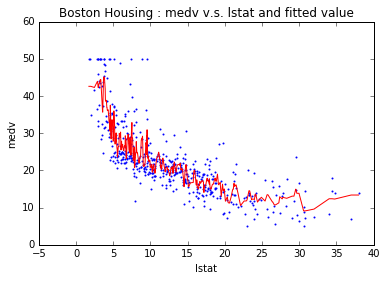

In [7]:
# set K
k = 5 

# initialize a KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=k)

# fit the model
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)

# compute the fitted value
predicted_medv = knn_model.predict(boston_housing[['lstat']])

# plot
plt.scatter(lstat, medv, s = 1, color = 'blue')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('Boston Housing : medv v.s. lstat and fitted value')
plt.plot(lstat, predicted_medv, color = 'red')

With $k = 5$ &ndash; a small number of nearest neighbors &ndash; we have a very "squiggly" predictor, which **fits the training data well** but is **over-sensitive to small changes** in the _lstat_ variable. We call this a **LOW-BIAS**, **HIGH-VARIANCE** predictor. We don't like it.

Now, with, say, $k = 200$, we have the following:

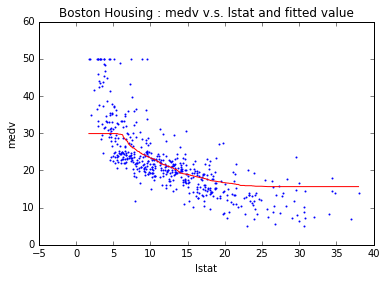

In [8]:
# set K
k = 200

# initialize a KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=k)

# fit the model
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)

# compute the fitted value
predicted_medv = knn_model.predict(boston_housing[['lstat']])

# plot
plt.scatter(lstat, medv, s = 1, color = 'blue')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('Boston Housing : medv v.s. lstat and fitted value')
plt.plot(lstat, predicted_medv, color = 'red')

_Meh..._, we're not exactly jumping around with joy with this one, either. The predictor line is **not over-sensitive**, but **too "smooth" and too simple**, **not responding sufficiently to significant changes** in _lstat_. We call this a **HIGH-BIAS, LOW-VARIANCE** predictor.

Let's try something in between, say, $k = 50$, to see if we have any better luck:

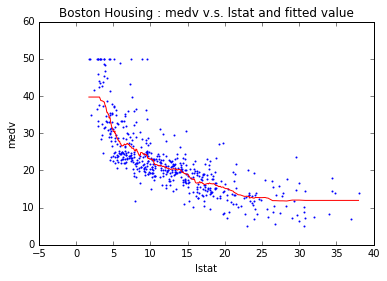

In [9]:
# set K
k = 50

# initialize a KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=k)

# fit the model
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)

# compute the fitted value
predicted_medv = knn_model.predict(boston_housing[['lstat']])

# plot
plt.scatter(lstat, medv, s = 1, color = 'blue')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('Boston Housing : medv v.s. lstat and fitted value')
plt.plot(lstat, predicted_medv, color = 'red')

Now, this looks pretty reasonable, and we'd think this predictor would **generalize well** when facing new, not yet seen, data. This is a **low-bias**, **low-variance** predictor. We love ones like this.

Hence, the key take-away is that, throughout a range of **hyper-parameter** $k$ from small to large, we have seen a spectrum of corresponding predictors from "low-bias high-variance" to "high-bias low-variance". This phenomenon is called the **BIAS-VARIANCE TRADE OFF**, a fundamental concept in Machine Learning that is applicable to not only KNN alone but to all modeling methods.

The bias-variance trade-off concerns the **generalizability of a trained predictor** in light of new data it's not seen before. If a predictor has high bias and/or high variance, it will not do well in new cases. **Good, generalizable predictors** need to have **both low bias and low variance**.

# Out-of-Sample Error and Cross-Validation

To **quantify the generalizability of a predictor**, we need to estimate its **out-of-sample (OOS) error**, i.e. a certain measure of **how well the predictor performs on data not used in its training process**.

A popular way to produce such OOS error estimates is to perform **cross validation**. Refer to lecture slides or <a href="http://en.wikipedia.org/wiki/Cross-validation_(statistics)">here</a> for discussions on cross validation.

Now, let's consider [**Root Mean Square Error** (**RMSE**)](http://en.wikipedia.org/wiki/Root-mean-square_deviation) as our predictor-goodness evaluation criterion and use **5-fold** cross validation **6 times** to pick a KNN predictor that has satisfactory RMSE.

In [10]:
# define Root-Mean-Square-Error scoring/evaluation function
# compliant with what SciKit Learn expects in this guide:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score
def rmse_score(estimator, X, y):
    y_hat = estimator.predict(X)
    return rmse(y_hat, y)

NB_CROSS_VALIDATION_FOLDS = 5
NB_CROSS_VALIDATIONS = 6

In [11]:
k_range = range(2, 201)
cross_validations_avg_rmse_dataframe = DataFrame(dict(k=k_range, model_complexity=-log(k_range)))
cross_validations_avg_rmse_dataframe['cv_avg_rmse'] = 0.
cv_column_names = []
for v in range(NB_CROSS_VALIDATIONS):
    cv_column_name = 'cv_%i_rmse' % v
    cv_column_names.append(cv_column_name)
    cross_validations_avg_rmse_dataframe[cv_column_name] = nan
    for k in k_range:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        avg_rmse_score = cross_val_score(
            knn_model,
            X=boston_housing[['lstat']],
            y=boston_housing.medv,
            cv=KFold(n=nb_samples,
                     n_folds=NB_CROSS_VALIDATION_FOLDS,
                     shuffle=True),
            scoring=rmse_score).mean()
        cross_validations_avg_rmse_dataframe.ix[
            cross_validations_avg_rmse_dataframe.k==k, cv_column_name] = avg_rmse_score
        
    cross_validations_avg_rmse_dataframe.cv_avg_rmse +=\
        (cross_validations_avg_rmse_dataframe[cv_column_name] -
         cross_validations_avg_rmse_dataframe.cv_avg_rmse) / (v + 1)
        
cross_validations_avg_rmse_longdataframe = melt(
    cross_validations_avg_rmse_dataframe,
    id_vars=['model_complexity', 'cv_avg_rmse'], value_vars=cv_column_names)


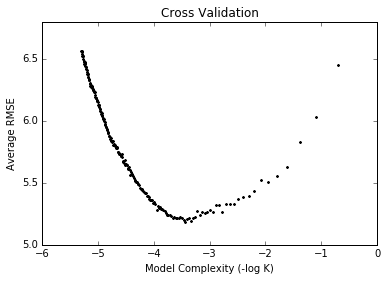

In [12]:
plt.scatter(cross_validations_avg_rmse_longdataframe['model_complexity'], cross_validations_avg_rmse_longdataframe['cv_avg_rmse'], s= 1)
plt.xlabel('Model Complexity (-log K)')
plt.ylabel('Average RMSE')
plt.title('Cross Validation')

Best $k$ that minimizes average cross-validation RMSE:

In [13]:
best_k_index = cross_validations_avg_rmse_dataframe.cv_avg_rmse.argmin()
best_k = k_range[best_k_index]
best_k

31

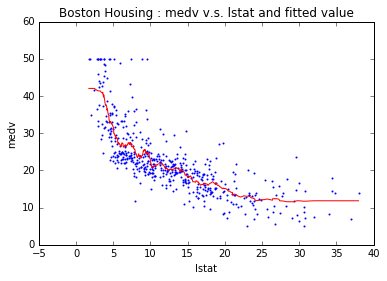

In [14]:
# redo KNN again, with the best K value returned by cross validation
k = best_k

# initialize a KNN regressor
knn_model = KNeighborsRegressor(n_neighbors=k)

# fit the model
knn_model.fit(X=boston_housing[['lstat']], y=boston_housing.medv)

# compute the fitted value
predicted_medv = knn_model.predict(boston_housing[['lstat']])

# plot
plt.scatter(lstat, medv, s = 1, color = 'blue')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('Boston Housing : medv v.s. lstat and fitted value')
plt.plot(lstat, predicted_medv, color = 'red')